### 1. Setup and Import Libraries

In [126]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import os
import warnings
warnings.filterwarnings("ignore")


### 2. Define File Paths and Load Data

In [127]:
# Define paths to local files
file_paths = {
    "TSLA": "../data/TSLA_proccessed_data.csv",
    "SPY": "../data/SPY_proccessed_data.csv",
    "BND": "../data/BND_proccessed_data.csv"
}

# Load data function
def load_data(file_path):
    return pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Load all datasets into a dictionary
data_dict = {ticker: load_data(path) for ticker, path in file_paths.items()}


### 3. Data Preprocessing and Feature Engineering

In [128]:
def preprocess_data(data):
    # Ensure 'Adj Close' column is numeric (convert if necessary)
    data['Adj Close'] = pd.to_numeric(data['Adj Close'], errors='coerce')
    
    # Basic data cleaning and feature engineering
    data['Return'] = data['Adj Close'].pct_change()
    data['Volatility'] = data['Return'].rolling(window=30).std()
    data['Rolling_Mean'] = data['Adj Close'].rolling(window=30).mean()
    
    # Lag features
    lags=[1, 2, 3]
    for lag in lags:
        data[f'Lag_{lag}'] = data['Adj Close'].shift(lag)
        
    # Drop NA rows from rolling and lagged features
    data.dropna(inplace=True)
    data= data.sort_index()
    return data
    
# Preprocess each dataset
for ticker, data in data_dict.items():
    data_dict[ticker] = preprocess_data(data)
    print(f'{ticker} preprocessed and feature engineered data')
    display(data_dict[ticker].head())
    print(data_dict[ticker]['Adj Close'].isna().sum())



TSLA preprocessed and feature engineered data


,Price,Adj Close,Close,High,Low,Open,Volume,Daily Return,Return,Volatility,Rolling_Mean,Lag_1,Lag_2,Lag_3
Date,,,,,,,,,,,,,,
2015-02-17 00:00:00+00:00,2015-02-17 00:00:00+00:00,13.623333,13.623332977294922,13.713333129882812,13.433333396911621,13.713333129882812,59694000,0.002846,0.002846,0.022889,13.754600,13.584667,13.525333,14.186667
2015-02-18 00:00:00+00:00,2015-02-18 00:00:00+00:00,13.630667,13.630666732788086,13.744667053222656,13.506667137145996,13.611332893371582,40704000,0.000538,0.000538,0.021611,13.742089,13.623333,13.584667,13.525333
2015-02-19 00:00:00+00:00,2015-02-19 00:00:00+00:00,14.114000,14.11400032043457,14.162667274475098,13.583333015441895,13.666666984558105,77311500,0.035459,0.035459,0.022576,13.743044,13.630667,13.623333,13.584667
2015-02-20 00:00:00+00:00,2015-02-20 00:00:00+00:00,14.474000,14.473999977111816,14.506667137145996,13.987333297729492,14.052000045776367,89731500,0.025507,0.025507,0.023035,13.756733,14.114000,13.630667,13.623333
2015-02-23 00:00:00+00:00,2015-02-23 00:00:00+00:00,13.822667,13.822667121887207,14.546667098999023,13.755332946777344,14.37733268737793,127497000,-0.045000,-0.045000,0.024532,13.749445,14.474000,14.114000,13.630667


0
SPY preprocessed and feature engineered data


,Price,Adj Close,Close,High,Low,Open,Volume,Daily Return,Return,Volatility,Rolling_Mean,Lag_1,Lag_2,Lag_3
Date,,,,,,,,,,,,,,
2015-02-17 00:00:00+00:00,2015-02-17 00:00:00+00:00,177.118896,210.11000061035156,210.32000732421875,209.10000610351562,209.39999389648438,76968200,0.001573,0.001573,0.009988,171.852814,176.840759,176.115799,174.438248
2015-02-18 00:00:00+00:00,2015-02-18 00:00:00+00:00,177.135849,210.1300048828125,210.22000122070312,209.33999633789062,209.66000366210938,80652900,0.000096,0.000096,0.009334,172.089132,177.118896,176.840759,176.115799
2015-02-19 00:00:00+00:00,2015-02-19 00:00:00+00:00,177.009338,209.97999572753906,210.4199981689453,209.24000549316406,209.41000366210938,91462500,-0.000714,-0.000714,0.009119,172.374622,177.135849,177.118896,176.840759
2015-02-20 00:00:00+00:00,2015-02-20 00:00:00+00:00,178.071503,211.24000549316406,211.3300018310547,208.72999572753906,209.47999572753906,140896400,0.006001,0.006001,0.008930,172.625550,177.009338,177.135849,177.118896
2015-02-23 00:00:00+00:00,2015-02-23 00:00:00+00:00,178.046219,211.2100067138672,211.2100067138672,210.47999572753906,210.94000244140625,74411100,-0.000142,-0.000142,0.008387,172.774760,178.071503,177.009338,177.135849


0
BND preprocessed and feature engineered data


,Price,Adj Close,Close,High,Low,Open,Volume,Daily Return,Return,Volatility,Rolling_Mean,Lag_1,Lag_2,Lag_3
Date,,,,,,,,,,,,,,
2015-02-17 00:00:00+00:00,2015-02-17 00:00:00+00:00,63.348412,82.47000122070312,82.80000305175781,82.44000244140625,82.77999877929688,5281500,-0.003986,-0.003986,0.002640,64.003706,63.601921,63.747864,63.717136
2015-02-18 00:00:00+00:00,2015-02-18 00:00:00+00:00,63.525093,82.69999694824219,82.81999969482422,82.48999786376953,82.58999633789062,3813000,0.002789,0.002789,0.002636,64.003117,63.348412,63.601921,63.747864
2015-02-19 00:00:00+00:00,2015-02-19 00:00:00+00:00,63.471352,82.62999725341797,82.80999755859375,82.5999984741211,82.73999786376953,1322700,-0.000846,-0.000846,0.002582,63.994604,63.525093,63.348412,63.601921
2015-02-20 00:00:00+00:00,2015-02-20 00:00:00+00:00,63.486694,82.6500015258789,82.87999725341797,82.52999877929688,82.75,3145800,0.000242,0.000242,0.002579,63.985324,63.471352,63.525093,63.348412
2015-02-23 00:00:00+00:00,2015-02-23 00:00:00+00:00,63.617294,82.81999969482422,82.88999938964844,82.75,82.80000305175781,3952700,0.002057,0.002057,0.002595,63.983722,63.486694,63.471352,63.525093


0


### 4. ARIMA and SARIMA Model Training and Evaluation

In [129]:
# Function for ARIMA and SARIMA models
def train_arima_models(data):
    # Split data into train and test sets
    train_size = int(len(data) * 0.8)
    train, test = data['Adj Close'][:train_size], data['Adj Close'][train_size:]
    
    # Train ARIMA model
    arima_model = auto_arima(train, seasonal=False, trace=True)
    arima_forecast = arima_model.predict(n_periods=len(test))
    
    # Train SARIMA model
    sarima_model = SARIMAX(train, order=arima_model.order, seasonal_order=(1,1,1,12))
    sarima_result = sarima_model.fit(disp=False)
    sarima_forecast = sarima_result.forecast(len(test))
        
    # Calculating MAE, RMSE, and MAPE for ARIMA
    arima_mae = mean_absolute_error(test, arima_forecast)
    arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
    arima_mape = np.mean(np.abs((test - arima_forecast) / test)) * 100  # MAPE for ARIMA

    # Calculating MAE, RMSE, and MAPE for SARIMA
    sarima_mae = mean_absolute_error(test, sarima_forecast)
    sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
    sarima_mape = np.mean(np.abs((test - sarima_forecast) / test)) * 100  # MAPE for SARIMA

    # Print results
    print(f"ARIMA MAE: {arima_mae:.4f}")
    print(f"ARIMA RMSE: {arima_rmse:.4f}")
    print(f"ARIMA MAPE: {arima_mape:.2f}%")

    print(f"SARIMA MAE: {sarima_mae:.4f}")
    print(f"SARIMA RMSE: {sarima_rmse:.4f}")
    print(f"SARIMA MAPE: {sarima_mape:.2f}%")
        
    return arima_forecast, sarima_forecast, test


### 5. PyTorch LSTM Model Definition and Training

#### Define LSTM Model

In [130]:
# Define the modified LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        last_time_step_output = lstm_out[:, -1, :]
        predictions = self.linear(last_time_step_output)
        return predictions

#### LSTM Model Training Function

In [131]:
# Function for training and evaluating LSTM model
def train_lstm_model(data, feature_cols):
    # Scale the features
    feature_scaler = MinMaxScaler(feature_range=(-1, 1))
    target_scaler = MinMaxScaler(feature_range=(-1, 1))

    # Apply feature scaling to feature columns
    data[feature_cols] = feature_scaler.fit_transform(data[feature_cols])
    data['Adj Close'] = target_scaler.fit_transform(data[['Adj Close']])

    # Prepare data for PyTorch LSTM
    sequence_length = 30
    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    def create_sequences(data, sequence_length):
        xs, ys = [], []
        for i in range(len(data) - sequence_length):
            x = data.iloc[i:i+sequence_length][feature_cols].values
            y = data.iloc[i+sequence_length]['Adj Close']  # Target is the next day's 'Adj Close'
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)
    
    X_train, y_train = create_sequences(train_data, sequence_length)
    X_test, y_test = create_sequences(test_data, sequence_length)
    
    # Create DataLoader for training
    train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=64, shuffle=True)
    
    # Define the LSTM model, loss function, and optimizer
    model = LSTMModel(input_size=len(feature_cols))
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    epochs = 10
    for epoch in range(epochs):
        model.train()
        for seq, labels in train_loader:
            optimizer.zero_grad()
            y_pred = model(seq)
            loss = loss_function(y_pred, labels.view(-1, 1))  # Reshape labels to match output
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item():.4f}")
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        test_inputs = torch.Tensor(X_test)
        y_pred = model(test_inputs).numpy()
    
    # Inverse scaling for predictions and true values using the target scaler
    y_pred = target_scaler.inverse_transform(y_pred)
    y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1))  # Reshape y_test to 2D for inverse_transform
    
    # Calculate evaluation metrics
    lstm_mae = mean_absolute_error(y_test, y_pred)
    lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    lstm_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # MAPE calculation
    
    print(f"LSTM MAE: {lstm_mae:.4f}")
    print(f"LSTM RMSE: {lstm_rmse:.4f}")
    print(f"LSTM MAPE: {lstm_mape:.2f}%")
    
    return model, y_pred, lstm_mae, lstm_rmse

### 6a. Train and Evaluate ARIMA, SARIMA, and LSTM Models for Tesla (TSLA)

#### ARIMA and SARIMA Models for TSLA

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12229.107, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12225.035, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12223.669, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12223.765, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12223.518, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12225.107, Time=0.61 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.373 seconds
ARIMA MAE: 36.6519
ARIMA RMSE: 46.1460
ARIMA MAPE: nan%
SARIMA MAE: 31.2217
SARIMA RMSE: 38.1622
SARIMA MAPE: nan%


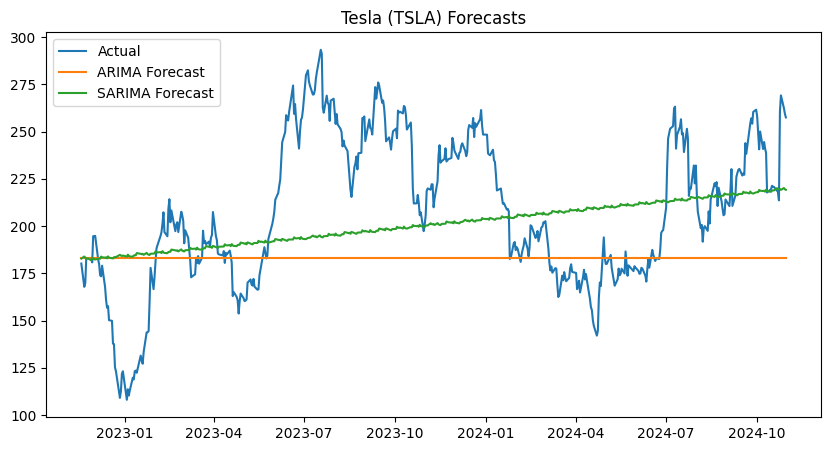

In [132]:
# Load the data for Tesla
tsla_data = data_dict['TSLA']

# Train ARIMA and SARIMA for Tesla (TSLA)
arima_forecast_tsla, sarima_forecast_tsla, test_tsla = train_arima_models(tsla_data)

# Plot Tesla Forecasts
plt.figure(figsize=(10, 5))
plt.plot(test_tsla.index, test_tsla, label="Actual")
plt.plot(test_tsla.index, arima_forecast_tsla, label="ARIMA Forecast")
plt.plot(test_tsla.index, sarima_forecast_tsla, label="SARIMA Forecast")
plt.legend()
plt.title("Tesla (TSLA) Forecasts")
plt.show()


#### LSTM Model for TSLA

In [133]:
# Train and evaluate LSTM model for Tesla (TSLA)
feature_cols = ['Adj Close', 'Return', 'Volatility', 'Rolling_Mean', 'Lag_1', 'Lag_2', 'Lag_3']
train_lstm_model(tsla_data, feature_cols)


Epoch 1/10 Loss: 0.1462
Epoch 2/10 Loss: 0.0010
Epoch 3/10 Loss: 0.0011
Epoch 4/10 Loss: 0.0042
Epoch 5/10 Loss: 0.0001
Epoch 6/10 Loss: 0.0012
Epoch 7/10 Loss: 0.0000
Epoch 8/10 Loss: 0.0008
Epoch 9/10 Loss: 0.0003
Epoch 10/10 Loss: 0.0060
LSTM MAE: 0.0314
LSTM RMSE: 0.0421
LSTM MAPE: 119.83%


(LSTMModel(
   (lstm): LSTM(7, 50, batch_first=True)
   (linear): Linear(in_features=50, out_features=1, bias=True)
 ),
 array([[-0.48318407],
        [-0.4616186 ],
        [-0.47680286],
        [-0.4696133 ],
        [-0.43929484],
        [-0.444763  ],
        [-0.42708385],
        [-0.42591047],
        [-0.43381888],
        [-0.3936628 ],
        [-0.40551898],
        [-0.41627926],
        [-0.39017048],
        [-0.34376517],
        [-0.34273332],
        [-0.34155563],
        [-0.27028084],
        [-0.19011064],
        [-0.22808537],
        [-0.20260671],
        [-0.16730098],
        [-0.14147173],
        [-0.13432765],
        [-0.11492093],
        [-0.10517085],
        [-0.08682865],
        [-0.06197609],
        [-0.0949764 ],
        [-0.10342865],
        [-0.04627186],
        [-0.02588429],
        [-0.06524661],
        [-0.03971468],
        [-0.07455423],
        [-0.06488176],
        [-0.05976751],
        [-0.0799707 ],
        [-0.03924975],
      

### 6b. Train and Evaluate ARIMA, SARIMA, and LSTM Models for S&P 500 (SPY)

#### ARIMA and SARIMA Models for SPY

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10269.305, Time=2.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10361.404, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10344.203, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10345.968, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10361.251, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10343.635, Time=0.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10343.937, Time=0.93 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10332.097, Time=3.90 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=10335.565, Time=4.97 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10343.220, Time=0.50 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=10344.235, Time=1.87 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10345.034, Time=1.53 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=4.07 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=10269.418, Time=1.58 sec

Best model:  ARIMA(2,1,2

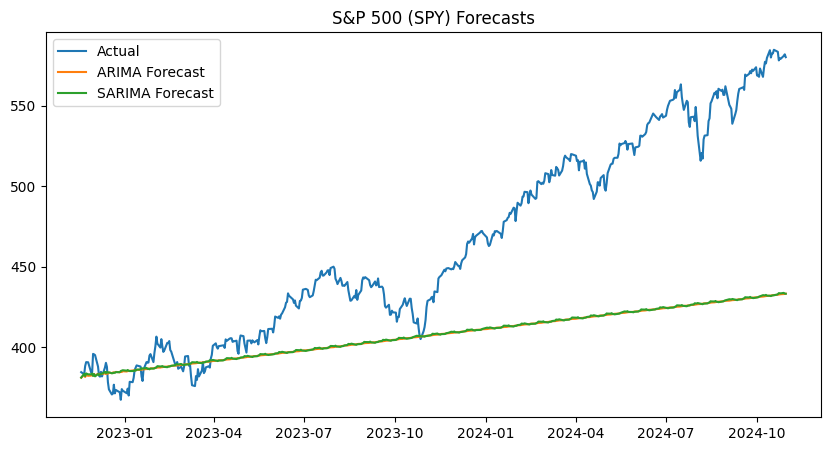

In [134]:
# Load the data for S&P 500
spy_data = data_dict['SPY']

# Train ARIMA and SARIMA for S&P 500 (SPY)
arima_forecast_spy, sarima_forecast_spy, test_spy = train_arima_models(spy_data)

# Plot S&P 500 Forecasts
plt.figure(figsize=(10, 5))
plt.plot(test_spy.index, test_spy, label="Actual")
plt.plot(test_spy.index, arima_forecast_spy, label="ARIMA Forecast")
plt.plot(test_spy.index, sarima_forecast_spy, label="SARIMA Forecast")
plt.legend()
plt.title("S&P 500 (SPY) Forecasts")
plt.show()


#### LSTM Model for SPY

In [135]:
# Train and evaluate LSTM model for S&P 500 (SPY)
train_lstm_model(spy_data, feature_cols)


Epoch 1/10 Loss: 0.0009
Epoch 2/10 Loss: 0.0155
Epoch 3/10 Loss: 0.0032
Epoch 4/10 Loss: 0.0003
Epoch 5/10 Loss: 0.0001
Epoch 6/10 Loss: 0.0004
Epoch 7/10 Loss: 0.0002
Epoch 8/10 Loss: 0.0001
Epoch 9/10 Loss: 0.0001
Epoch 10/10 Loss: 0.0008
LSTM MAE: 0.0889
LSTM RMSE: 0.1192
LSTM MAPE: 20.02%


(LSTMModel(
   (lstm): LSTM(7, 50, batch_first=True)
   (linear): Linear(in_features=50, out_features=1, bias=True)
 ),
 array([[0.01410055],
        [0.01840504],
        [0.01300059],
        [0.02432159],
        [0.02530109],
        [0.03009117],
        [0.03937162],
        [0.04504378],
        [0.05090556],
        [0.05477609],
        [0.05066453],
        [0.04832263],
        [0.05768198],
        [0.06428666],
        [0.06537656],
        [0.06825627],
        [0.07686439],
        [0.08150573],
        [0.07839389],
        [0.08797421],
        [0.09654275],
        [0.10795231],
        [0.10848975],
        [0.11019345],
        [0.1205512 ],
        [0.11844559],
        [0.11575471],
        [0.11760323],
        [0.12363102],
        [0.12449099],
        [0.12788974],
        [0.12335664],
        [0.12282129],
        [0.11229782],
        [0.10859878],
        [0.10779746],
        [0.09878643],
        [0.09691708],
        [0.09241156],
        [0.08767724],


### 6c. Train and Evaluate ARIMA, SARIMA, and LSTM Models for Bonds (BND)

#### ARIMA and SARIMA Models for BND

Performing stepwise search to minimize aic


 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.01 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1183.444, Time=0.29 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=760.185, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1181.445, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=505.931, Time=0.33 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=291.899, Time=0.45 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=144.300, Time=0.56 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=92.124, Time=0.91 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=-152.738, Time=4.65 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-165.171, Time=3.24 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-172.102, Time=3.98 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.32 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.54 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC

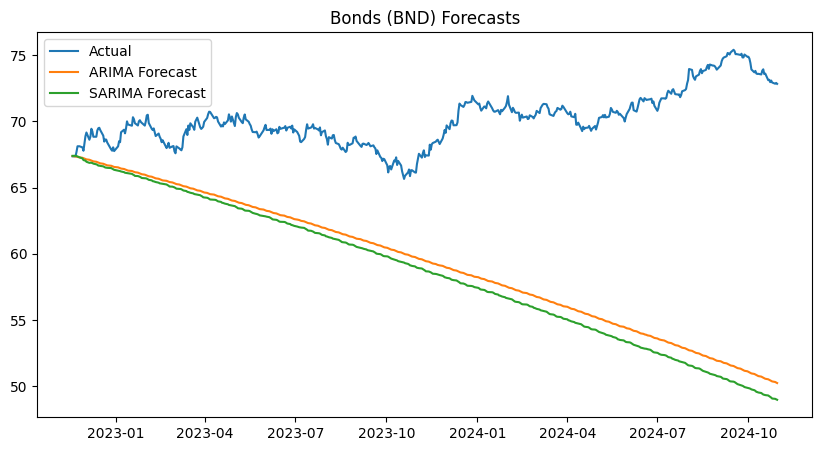

In [136]:
# Load the data for Bonds
bnd_data = data_dict['BND']

# Train ARIMA and SARIMA for Bonds (BND)
arima_forecast_bnd, sarima_forecast_bnd, test_bnd = train_arima_models(bnd_data)

# Plot Bonds Forecasts
plt.figure(figsize=(10, 5))
plt.plot(test_bnd.index, test_bnd, label="Actual")
plt.plot(test_bnd.index, arima_forecast_bnd, label="ARIMA Forecast")
plt.plot(test_bnd.index, sarima_forecast_bnd, label="SARIMA Forecast")
plt.legend()
plt.title("Bonds (BND) Forecasts")
plt.show()


#### LSTM Model for BND



In [137]:
# Train and evaluate LSTM model for Bonds (BND)
train_lstm_model(bnd_data, feature_cols)


Epoch 1/10 Loss: 0.0372
Epoch 2/10 Loss: 0.0138
Epoch 3/10 Loss: 0.0011
Epoch 4/10 Loss: 0.0028
Epoch 5/10 Loss: 0.0009
Epoch 6/10 Loss: 0.0018
Epoch 7/10 Loss: 0.0011
Epoch 8/10 Loss: 0.0008
Epoch 9/10 Loss: 0.0036
Epoch 10/10 Loss: 0.0039
LSTM MAE: 0.0450
LSTM RMSE: 0.0556
LSTM MAPE: 287.26%


(LSTMModel(
   (lstm): LSTM(7, 50, batch_first=True)
   (linear): Linear(in_features=50, out_features=1, bias=True)
 ),
 array([[-3.58336926e-01],
        [-3.54811996e-01],
        [-3.51697028e-01],
        [-3.31817985e-01],
        [-3.07545245e-01],
        [-2.89834499e-01],
        [-2.63585508e-01],
        [-2.33027428e-01],
        [-2.14354008e-01],
        [-1.98999882e-01],
        [-1.74746960e-01],
        [-1.61326826e-01],
        [-1.56811237e-01],
        [-1.53996855e-01],
        [-1.50145113e-01],
        [-1.49789870e-01],
        [-1.53066546e-01],
        [-1.55002683e-01],
        [-1.59802616e-01],
        [-1.59427494e-01],
        [-1.52468562e-01],
        [-1.45940363e-01],
        [-1.46987528e-01],
        [-1.51283860e-01],
        [-1.57959461e-01],
        [-1.67699009e-01],
        [-1.84285015e-01],
        [-2.02946544e-01],
        [-2.14144886e-01],
        [-2.28473097e-01],
        [-2.42897332e-01],
        [-2.56967217e-01],
        [-2.6683